# Frank Sinatra RNN Lyrics Generator
> Author: Hannan Khan  
> Date: 2022-05-17 19:45:03

## Setting Up Vars

### Loading Libraries

In [43]:
import tensorflow as tf

import numpy as np
import os
import time

import matplotlib.pyplot as plt

### Loading The Dataset For The Model

The actual creation of the dataset can be seen in [genius_scraper.py](https://github.com/hannankhan888/Sinatra_Lyrics_Generator_RNN/blob/main/data_scraping/genius_scraper.py) where I used the Genuis API to scrape Frank Sinatra's lyrics. In order to create the text file used below, run:  
[genius_scraper.py](https://github.com/hannankhan888/Sinatra_Lyrics_Generator_RNN/blob/main/data_scraping/genius_scraper.py) ==> [json_to_csv.py](https://github.com/hannankhan888/Sinatra_Lyrics_Generator_RNN/blob/main/data_scraping/json_to_csv.py) ==> [csv_to_txt.py](https://github.com/hannankhan888/Sinatra_Lyrics_Generator_RNN/blob/main/data_scraping/csv_to_txt.py)

In [16]:
data_path = r'data'
filename = 'Lyrics_FrankSinatra.txt'
filepath = os.sep.join([data_path, filename])
checkpoint_path = r'checkpoints'

text = ''
with open(filepath, encoding='utf-8') as f:
    text = f.read()

print(f"len(text) = {len(text)}")
print("Example:", text[:50])

len(text) = 705123
Example: fly me to the moon let me play among the stars and


In [60]:
vocab = sorted(set(text))
print(f"len(vocab) = {len(vocab)}")

len(vocab) = 27


In [18]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(),
                                             invert=True, mask_token=None)
# below fn is for a single char
# def text_from_ids(ids):
#     return chars_from_ids(ids).numpy().decode('utf-8')
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(705123,), dtype=int64, numpy=array([ 7, 13, 26, ..., 24,  2, 26], dtype=int64)>

In [19]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

# this operation is only for single data points (chars), not batches.
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'), end='')

fly me to 

In [20]:
sequence_len = 100

sequences = ids_dataset.batch(sequence_len+1, drop_remainder=True)
for seq in sequences.take(5):
    print(text_from_ids(seq))

tf.Tensor(b'fly me to the moon let me play among the stars and let me see what spring is like on ajupiter and mar', shape=(), dtype=string)
tf.Tensor(b's in other words hold my hand in other words baby kiss me fill my heart with song and let me sing for', shape=(), dtype=string)
tf.Tensor(b'evermore you are all i long for all i worship and adore in other words please be true in other words ', shape=(), dtype=string)
tf.Tensor(b'i love you fill my heart with song let me sing forevermore you are all i long for all i worship and a', shape=(), dtype=string)
tf.Tensor(b'dore in other words please be true in other words in other words i love youand now the end is near an', shape=(), dtype=string)


In [21]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [22]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'fly me to the moon let me play among the stars and let me see what spring is like on ajupiter and ma'
Target: b'ly me to the moon let me play among the stars and let me see what spring is like on ajupiter and mar'


In [23]:
BATCH_SIZE = 128

# used to shuffle the dataset
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))
dataset

<PrefetchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

## Creating The RNN Model

### Defining The `LyricsGeneratorModel()` Class & Testing

In [24]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

In [25]:
class LyricsGeneratorModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
        
        if return_state:
            return x, states
        else:
            return x

In [26]:
model = LyricsGeneratorModel(vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            rnn_units=rnn_units)

In [27]:
for input_batch, target_batch in dataset.take(1):
    predictions = model(input_batch)
    print(predictions.shape, '(batch, seq_length, vocab_size)')

(128, 100, 28) (batch, seq_length, vocab_size)


In [28]:
model.summary()

Model: "lyrics_generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  7168      
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  28700     
Total params: 3,974,172
Trainable params: 3,974,172
Non-trainable params: 0
_________________________________________________________________


In [29]:
example_idxs = tf.random.categorical(predictions[0], num_samples=1)
example_idxs = tf.squeeze(example_idxs, axis=-1).numpy()

print(f'Input: {text_from_ids(input_batch[0]).numpy()}')
print(f'Next char predictions:')
print(f'{text_from_ids(example_idxs).numpy()}')

Input: b's i see soon begins bewitching me its that old devil moon that you stole from the skies its that old'
Next char predictions:
b't[UNK]vtbpszf nqycgt uwweyzryjcxsdeiqqag uo fobxzqmqqsxmmv lxxbvizzmuubptzikawishqnlp lntuwxgnwud[UNK]maqlrp'


In [30]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

example_mean_loss = loss_fn(target_batch, predictions)
print(f'Predictions shape: {predictions.shape}')
print(f'Mean Loss: {example_mean_loss}')

Predictions shape: (128, 100, 28)
Mean Loss: 3.3320910930633545


A new model should not be too confident. The output logits should all have similar magnitudes. The exponential of the mean loss should be approximately equal to the vocabulary size.

In [31]:
tf.exp(example_mean_loss).numpy()

27.996824

### Compiling & Running The Model

In [32]:
model.compile(optimizer='adam', loss=loss_fn)

In [33]:
# we create checkpoints for saving during training:
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                        save_weights_only=True)

In [35]:
EPOCHS = 80
# history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/80
54/54 [==============================] - 89s 2s/step - loss: 2.7600
Epoch 2/80
54/54 [==============================] - 112s 2s/step - loss: 2.1935
Epoch 3/80
54/54 [==============================] - 119s 2s/step - loss: 2.0151
Epoch 4/80
54/54 [==============================] - 117s 2s/step - loss: 1.8745
Epoch 5/80
54/54 [==============================] - 128s 2s/step - loss: 1.7569
Epoch 6/80
54/54 [==============================] - 133s 2s/step - loss: 1.6579
Epoch 7/80
54/54 [==============================] - 125s 2s/step - loss: 1.5739
Epoch 8/80
54/54 [==============================] - 129s 2s/step - loss: 1.5056
Epoch 9/80
54/54 [==============================] - 129s 2s/step - loss: 1.4477
Epoch 10/80
54/54 [==============================] - 128s 2s/step - loss: 1.3987
Epoch 11/80
54/54 [==============================] - 125s 2s/step - loss: 1.3531
Epoch 12/80
54/54 [==============================] - 125s 2s/step - loss: 1.3115
Epoch 13/80
54/54 [===================

In [64]:
model.save(f"model_lower_char_{EPOCHS}_epochs")
model.save_weights(f"model_lower_char_{EPOCHS}_epochs_weights.h5")

INFO:tensorflow:Assets written to: model_lower_char_80_epochs\assets


INFO:tensorflow:Assets written to: model_lower_char_80_epochs\assets


### Setting Up A Prediction Function
Courtesy of the [TensorFlow text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation).

In [61]:
# Create a mask to prevent "[UNK]" from being generated.
skip_ids = ids_from_chars(['[UNK]'])[:, None]
sparse_mask = tf.SparseTensor(
    # Put a -inf at each bad index.
    values=[-float('inf')]*len(skip_ids),
    indices=skip_ids,
    # Match the shape to the vocabulary
    dense_shape=[len(ids_from_chars.get_vocabulary())])
prediction_mask = tf.sparse.to_dense(sparse_mask)

def generate_one_step(inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = model(inputs=input_ids, states=states,
                                          return_state=True, training=False)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/1.0
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

## Model Performance & Predictions
This model had great loss, with a min of 0.09. However, as I noticed by testing the predicitons, the model might have ran for too long, and might have gotten overfit to the data.  

For example, the model might get caught in a 'jingle bells' loop as I call it. There it will only be printing the lyrics to Jingle Bells. There are however, a few times it releases itself from the loop.

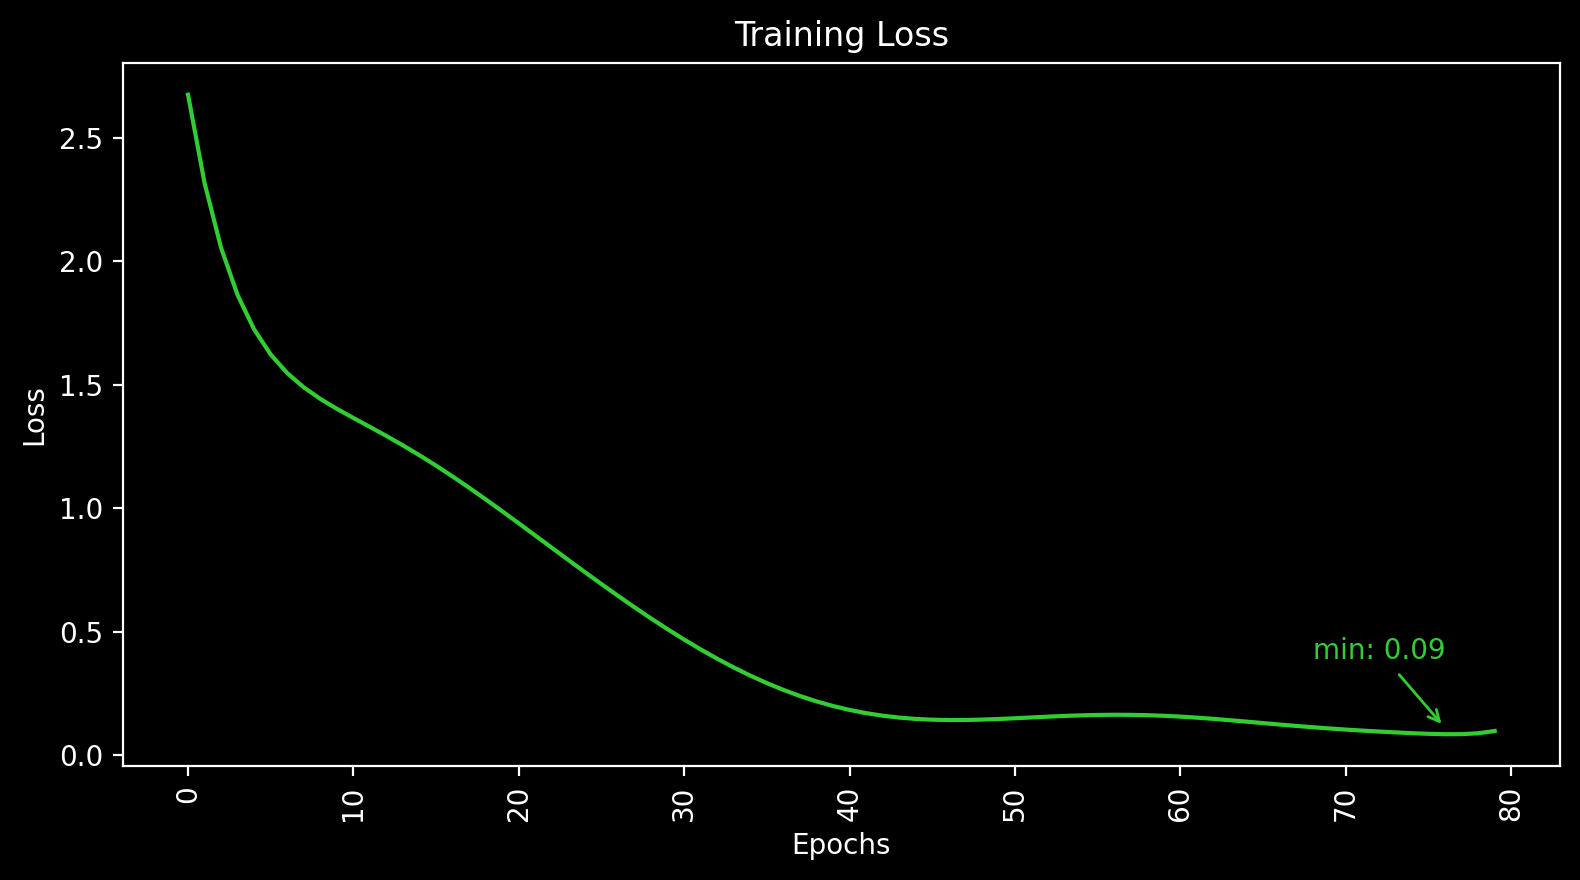

In [84]:
def plot_loss(loss_list: list = [], title: str = ""):
    x = range(len(loss_list))
    y = loss_list
    
    z = np.polyfit(x, y, 10)
    p = np.poly1d(z)
    trnd_ln_arr = p(x)
    
    plt.figure(figsize=(8, 4.5), dpi=200)
    plt.style.use('dark_background')
    
    plt.plot(x, trnd_ln_arr, color='limegreen')
    plt.xticks(rotation=90)
    
    ymin = round(min(p(x)), 2)
    x_pos = np.argmin(trnd_ln_arr, 0)
    xmin = x[x_pos]

    plt.annotate(f"min: {ymin}",xy=(xmin, ymin+.02), xytext=(xmin, ymin+.3),
                 horizontalalignment='right',
                 arrowprops=dict(arrowstyle='->',color='limegreen'),
                color='limegreen')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    plt.savefig('data\\' + title)
    plt.show()

plot_loss(history.history['loss'], 'Training Loss')

In [85]:
start = time.time()
states = None
next_char = tf.constant(['L'])
result = [next_char]

for n in range(1000):
  next_char, states = generate_one(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Lme but thanks for the memory of every touch a thrill ive been through the mill ive lived a lot and learn to break when youre cryin you bring on the rain so stop that sighin come on and be happy again keep on smilin cause when youre smilin baby the whole world smiles with youallywsllen by the window where i can see all those marvelous things to be seen out there what do i care you and me keep is through all i remember out way dear dreams well confess the sunshine for more than the greatest love the world has luck pose from you even stop late through the night and the day till my eyes get were one love like you and the other knows and the sun just im a guy who loves a clinging vine kiss me baby kiss me and though i know her known the blacked out and the earth bells jingle bells jingle all the way oh what fun its a lonely town unless theres love a love thats shining like a harbor light youre lost in the night our end was in your eyes bright as the starress its up to you from the bottom t